In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kurtosis, skew


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('/home/aditya/Forcasting_scheduling_project/code /open-meteo-17.25N74.12E572m.csv')

In [4]:
df.shape

(30288, 8)

In [5]:
df.head()

,time,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),wind_speed_10m (km/h),cloud_cover (%),surface_pressure (hPa),direct_radiation (W/m²)
0,2022-01-01T00:00,22.3,59,13.9,7.4,96,950.9,0.0
1,2022-01-01T01:00,22.0,61,14.1,6.5,100,951.6,0.0
2,2022-01-01T02:00,21.7,64,14.6,5.9,100,952.5,1.0
3,2022-01-01T03:00,22.5,62,14.8,9.2,100,953.3,27.0
4,2022-01-01T04:00,23.9,57,14.8,15.5,51,953.8,174.0


In [6]:
df['time']= pd.to_datetime(df['time'])

In [7]:
print(df.isnull().sum().sum())
print(df.duplicated().sum().sum())

0
0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30288 entries, 0 to 30287
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   time                      30288 non-null  datetime64[ns]
 1   temperature_2m (°C)       30288 non-null  float64       
 2   relative_humidity_2m (%)  30288 non-null  int64         
 3   dew_point_2m (°C)         30288 non-null  float64       
 4   wind_speed_10m (km/h)     30288 non-null  float64       
 5   cloud_cover (%)           30288 non-null  int64         
 6   surface_pressure (hPa)    30288 non-null  float64       
 7   direct_radiation (W/m²)   30288 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 1.8 MB


In [9]:
df['temp_tomorrow'] = df['temperature_2m (°C)'].shift(-24)

In [10]:
df['time_tomorrow'] = df['time'].shift(-24)

In [11]:
df['time'].dt.year.value_counts().sort_index()

time
2022    8760
2023    8760
2024    8784
2025    3984
Name: count, dtype: int64

### Univariate analysis

In [12]:
print("unique values \n", df.nunique())

unique values 
 time                        30288
temperature_2m (°C)           343
relative_humidity_2m (%)       94
dew_point_2m (°C)             272
wind_speed_10m (km/h)         350
cloud_cover (%)               103
surface_pressure (hPa)        212
direct_radiation (W/m²)       939
temp_tomorrow                 343
time_tomorrow               30264
dtype: int64


In [13]:
df = df.dropna()

In [14]:
df.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
temperature_2m (°C),30264.0,25.095384,5.496195,5.5,22.1,24.5,28.5,41.5
relative_humidity_2m (%),30264.0,66.439631,23.959840,7.0,47.0,72.0,87.0,100.0
dew_point_2m (°C),30264.0,16.928889,4.985598,-3.4,13.4,18.4,21.1,25.5
wind_speed_10m (km/h),30264.0,7.378215,5.543512,0.0,3.2,5.6,10.4,39.5
cloud_cover (%),30264.0,57.898625,38.910145,-1.0,16.0,64.0,100.0,101.0
surface_pressure (hPa),30264.0,946.293028,3.316329,935.1,944.0,946.4,948.6,956.6
direct_radiation (W/m²),30264.0,156.046689,245.298826,0.0,0.0,1.0,259.0,951.0
temp_tomorrow,30264.0,25.096220,5.495593,5.5,22.1,24.5,28.5,41.5


In [15]:
df['cloud_cover (%)'] = df['cloud_cover (%)'].apply(
    lambda x: 0 if x < 0 else 100 if x > 100 else x
)


<Figure size 640x480 with 0 Axes>

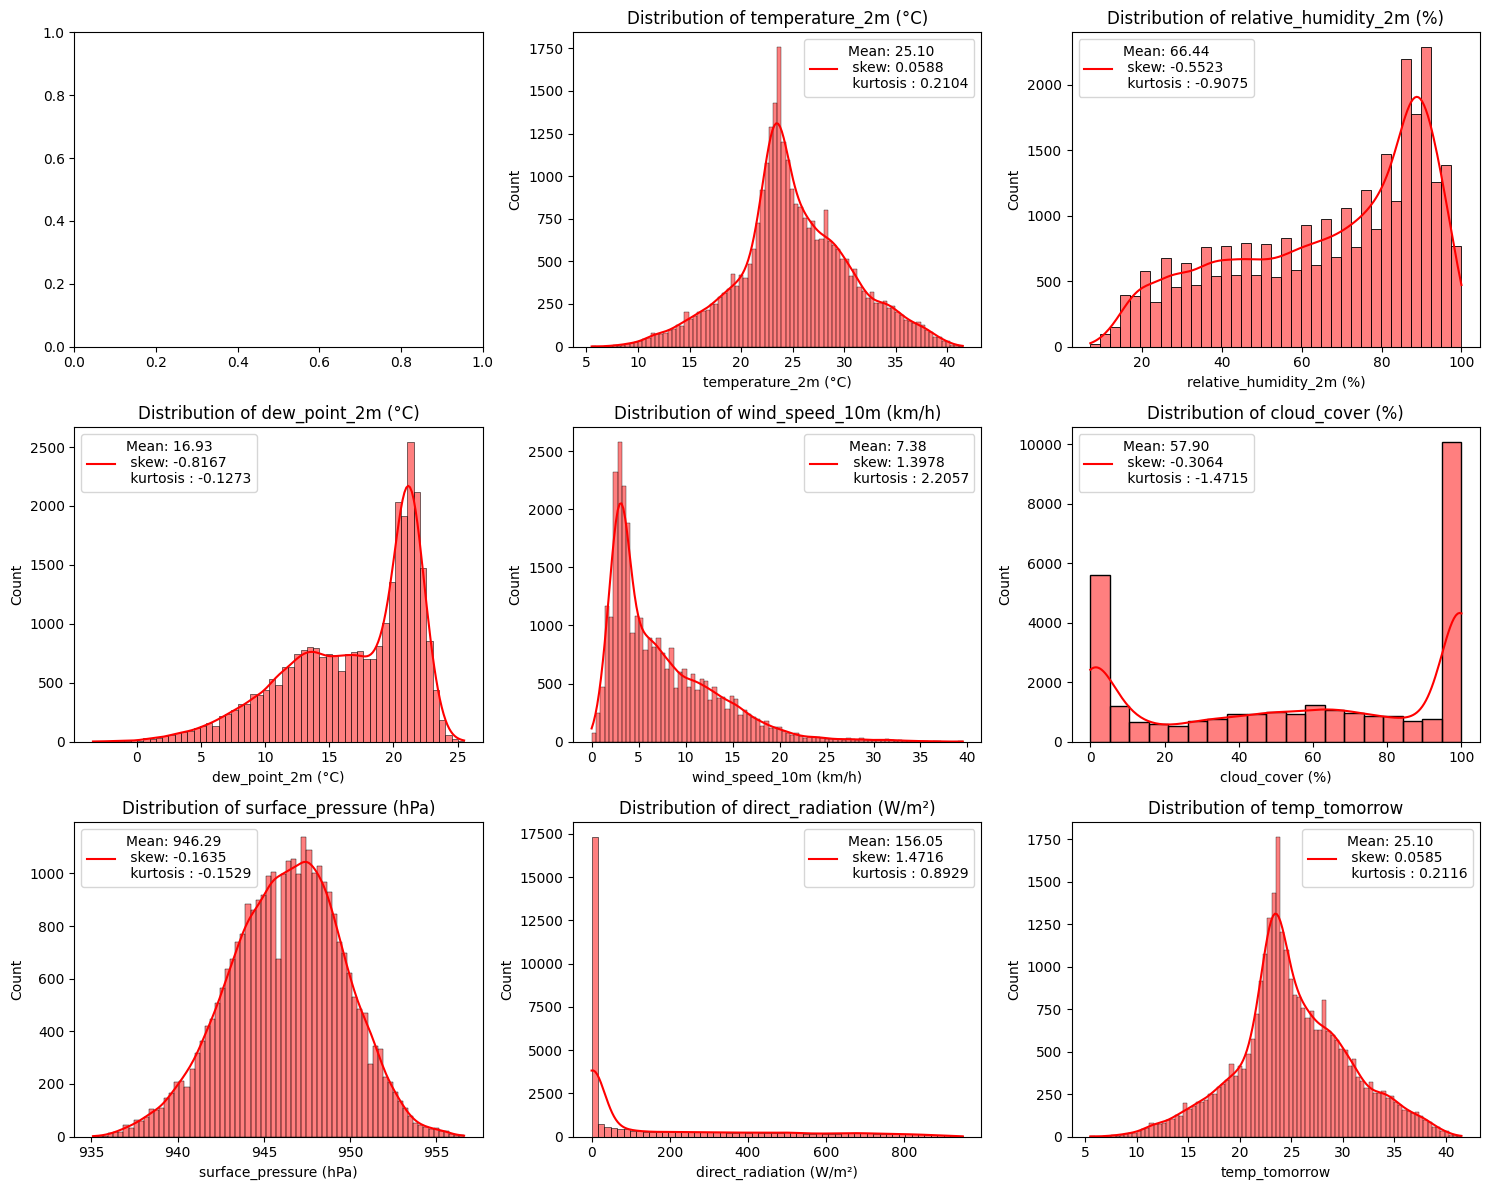

In [16]:
plt.figure()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    if pd.api.types.is_numeric_dtype(df[col]):
        sns.histplot(data=df, x=col, kde=True, color='red', ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].legend([f"Mean: {df[col].mean():.2f} \n skew: {round(df[col].skew(),4)} \n kurtosis : {round(df[col].kurtosis(),4)}"])


plt.tight_layout()
plt.show()

### Bivariate analysis

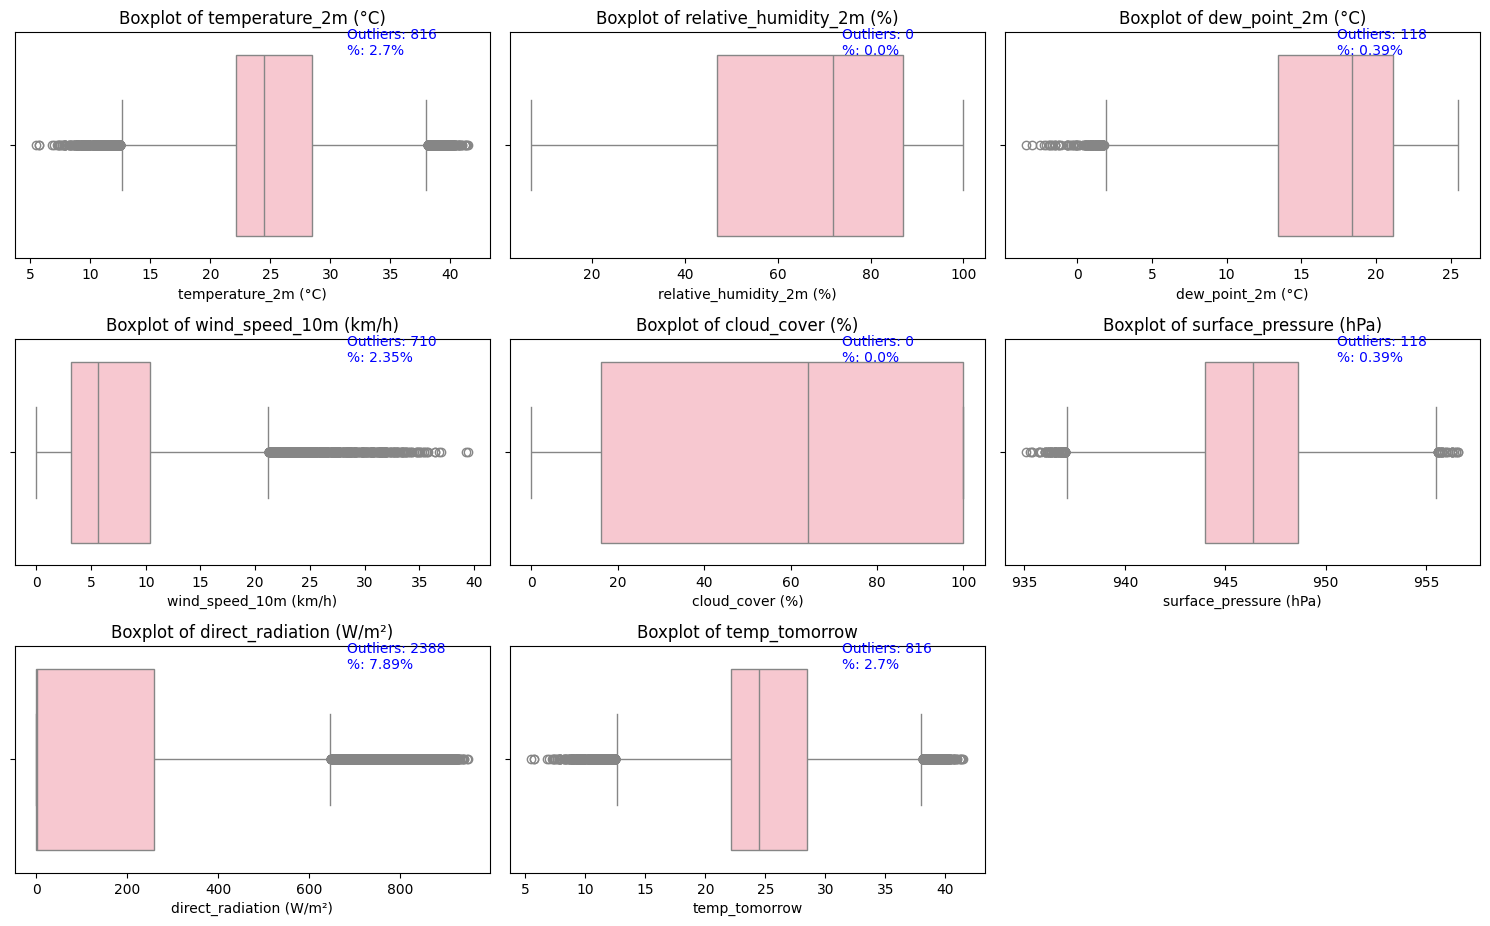

In [17]:
def outlier_percentage(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = series[(series < lower_bound) | (series > upper_bound)]
    outlier_pct = (len(outliers) / len(series)) * 100

    return round(outlier_pct, 2), len(outliers)  



plt.figure(figsize=(15, 12))
numeric_cols = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]

for i, col in enumerate(numeric_cols):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x=df[col], color='pink')
    
    outlier_pct, total_outliers = outlier_percentage(df[col])
    plt.title(f'Boxplot of {col}')
    
    # Add outlier info as text inside plot
    plt.text(
        x=0.7, y=0.9, s=f"Outliers: {total_outliers}\n%: {outlier_pct}%",
        transform=plt.gca().transAxes, fontsize=10, color='blue'
    )

plt.tight_layout()
plt.show()


### Bivariate analysis

<Axes: >

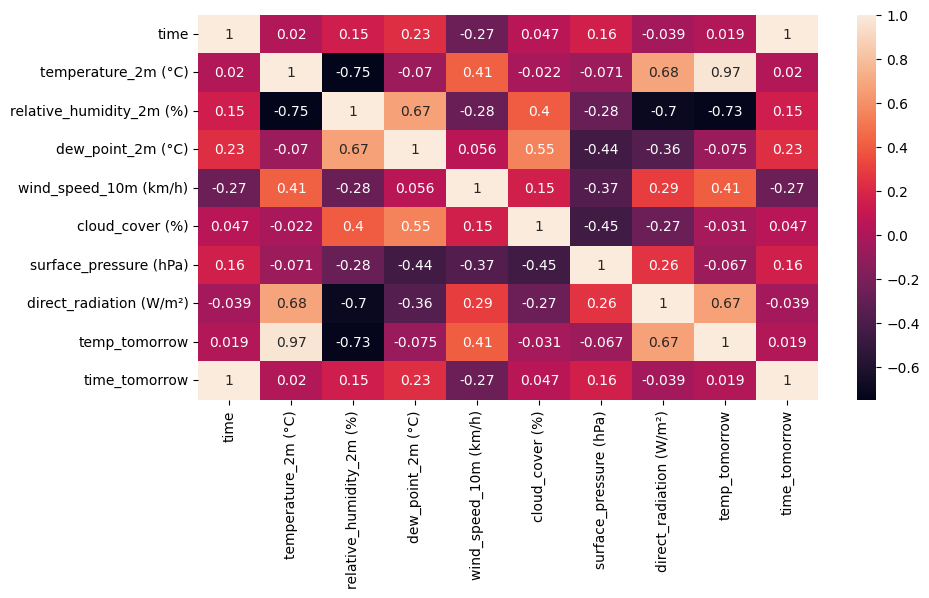

In [18]:
fig, ax = plt.subplots(figsize = (10,5))
sns.heatmap(df.corr(), ax = ax, annot = True)

In [19]:
corr_series = df.corr(numeric_only=True)['temp_tomorrow'].sort_values()
corr_series.sort_values(ascending=False)

temp_tomorrow               1.000000
temperature_2m (°C)         0.967855
direct_radiation (W/m²)     0.668646
wind_speed_10m (km/h)       0.411320
cloud_cover (%)            -0.031089
surface_pressure (hPa)     -0.066828
dew_point_2m (°C)          -0.074775
relative_humidity_2m (%)   -0.728662
Name: temp_tomorrow, dtype: float64

In [20]:
## Transformation 
def winsorize_column(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return col.clip(lower=lower_bound, upper=upper_bound)


features = df.drop(columns=['time', 'temp_tomorrow','time_tomorrow'], errors='ignore')
features = features.apply(winsorize_column)

df_transformed = features.copy()
df_transformed['temp_tomorrow'] = df['temp_tomorrow'].values

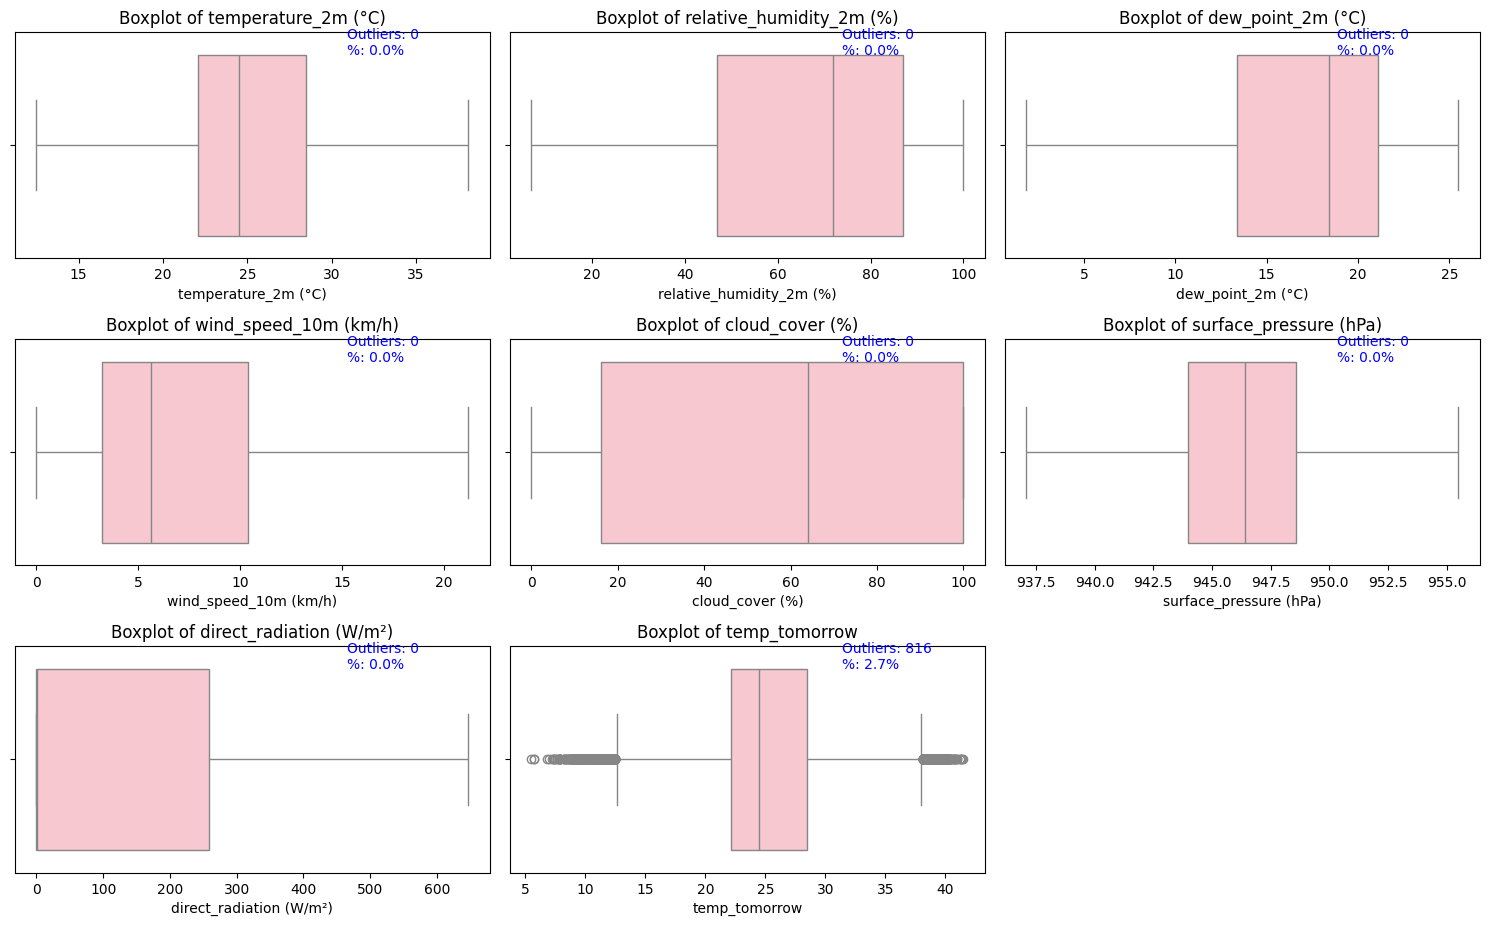

In [21]:
def outlier_percentage(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = series[(series < lower_bound) | (series > upper_bound)]
    outlier_pct = (len(outliers) / len(series)) * 100

    return round(outlier_pct, 2), len(outliers)  



plt.figure(figsize=(15, 12))
numeric_cols = [col for col in df_transformed.columns if pd.api.types.is_numeric_dtype(df_transformed[col])]

for i, col in enumerate(numeric_cols):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x=df_transformed[col], color='pink')
    
    outlier_pct, total_outliers = outlier_percentage(df_transformed[col])
    plt.title(f'Boxplot of {col}')
    
    # Add outlier info as text inside plot
    plt.text(
        x=0.7, y=0.9, s=f"Outliers: {total_outliers}\n%: {outlier_pct}%",
        transform=plt.gca().transAxes, fontsize=10, color='blue'
    )

plt.tight_layout()
plt.show()


In [22]:
def fix_skewness(df, threshold=0.5):
    df_fixed = df.copy()
    skewed_cols = []

    for col in df.columns:
        if df[col].dtype != 'float64' and df[col].dtype != 'int64' and col != 'temp_tomorrow':
            continue  

        col_skew = skew(df[col].dropna())
        if abs(col_skew) > threshold:
            skewed_cols.append((col, col_skew))


            if (df[col] >= 0).all():
                df_fixed[col] = np.log1p(df[col])
            else:
                
                df_fixed[col] = np.sqrt(df[col] - df[col].min() + 1)

    return df_fixed, skewed_cols


In [23]:
df_transformed, skewed_cols =  fix_skewness(df)

In [24]:
skewed_cols

[('relative_humidity_2m (%)', np.float64(-0.5522463749105623)),
 ('dew_point_2m (°C)', np.float64(-0.8166435330695705)),
 ('wind_speed_10m (km/h)', np.float64(1.3976910088180743)),
 ('direct_radiation (W/m²)', np.float64(1.4714820398268615))]

In [25]:
x = df_transformed.iloc[:, 1: 8]
y = df_transformed['temp_tomorrow']

print("x type ",type(x))
print("y type",type(y))

x type  <class 'pandas.core.frame.DataFrame'>
y type <class 'pandas.core.series.Series'>


In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)
print(f"x_train_shpae : {x_train.shape}")
print(f"x_test_shpae : {x_test.shape}")
print(f"y_train_shpae : {y_train.shape}")
print(f"y_test_shpae : {y_test.shape}")

x_train_shpae : (24211, 7)
x_test_shpae : (6053, 7)
y_train_shpae : (24211,)
y_test_shpae : (6053,)


In [27]:
## Scaling 
from sklearn.preprocessing import StandardScaler

In [28]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train) 
x_test_scaled = scaler.transform(x_test)    

### Model building

In [29]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-6))) * 100

def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

In [31]:
models = {

    "Random Forest": RandomForestRegressor(random_state=42),
    
}

In [32]:
import time

results = {}

for name, model in models.items():
    start = time.time()
    
    model.fit(x_train_scaled, y_train)
    y_pred = model.predict(x_test_scaled)
    
    end = time.time()
    elapsed_time = end - start

    r2 = r2_score(y_test, y_pred)
    n, k = x_test.shape
    adj_r2 = adjusted_r2(r2, n, k)

    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R² Score": r2,
        "Adjusted R²": adj_r2,
        "MAPE (%)": mean_absolute_percentage_error(y_test, y_pred),
        "Time Taken (s)": round(elapsed_time, 3)
    }


In [33]:
results_df = pd.DataFrame(results).T.sort_values(by="RMSE")
print("\nModel Evaluation Metrics:")
print(results_df.round(4))


Model Evaluation Metrics:
                  MAE     MSE    RMSE  R² Score  Adjusted R²  MAPE (%)  \
Random Forest  0.9316  1.7627  1.3277    0.9403       0.9402    4.0226   

               Time Taken (s)  
Random Forest          10.499  
